## Carregando Bibliotecas e Drive

In [0]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/covid19

/content/drive/My Drive/Colab Notebooks/covid19


In [0]:
!ls

API_SP.POP.TOTL_DS2_en_csv_v2_887275.csv
brasil_20200324.csv
brasil_20200326.csv
Brasil_20200327.html
Brasil_covid19.html
casos.png
covid19Brazil-script.ipynb
covid19-script.ipynb
covid19-SEIR_Bayes.ipynb
full_data_20200320.csv
full_data_20200321.csv
full_data_20200322.csv
full_data_20200323.csv
full_data_20200326.csv
Metadata_Country_API_SP.POP.TOTL_DS2_en_csv_v2_887275.csv
Metadata_Indicator_API_SP.POP.TOTL_DS2_en_csv_v2_887275.csv
mortes.png
novos_casos.png
teste.png


## Modelo
adaptado de https://github.com/3778/COVID-19

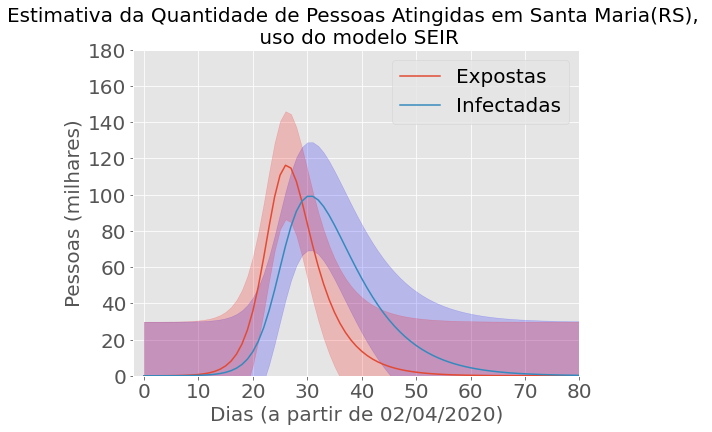

In [0]:
def run_SEIR_ODE_model(
        N: 'population size',
        E0: 'init. exposed population',
        I0: 'init. infected population',
        R0: 'init. removed population',
        beta: 'infection probability',
        gamma: 'removal probability', 
        alpha_inv: 'incubation period', 
        t_max: 'numer of days to run'
    ) -> pd.DataFrame:

    S0 = N - I0 - R0 - E0
    alpha = 1/alpha_inv

    # A grid of time points (in days)
    t = range(t_max)

    # The SEIR model differential equations.
    def deriv(y, t, N, beta, gamma, alpha):
        S, E, I, R = y
        dSdt = -beta * S * I / N
        dEdt = -dSdt - alpha*E
        dIdt = alpha*E - gamma*I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt

    # Initial conditions vector
    y0 = S0, E0, I0, R0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, alpha))
    S, E, I, R = ret.T

    return pd.DataFrame({'S': S, 'E': E, 'I': I, 'R': R}, index=t)


if __name__ == '__main__':
    N = 282123 #população de SM-RS
    E0, I0, R0 = 0, 8, 0 #contaminados inicialmente em SM-RS
    beta, gamma, alpha_inv = 1.75, 0.15, 5.2 #valores padrão
    t_max = 100 
    results = run_SEIR_ODE_model(N, E0, I0, R0, beta, gamma, alpha_inv, t_max)

    # plot
    plt.style.use('ggplot')
    (results.div(1000)
     [['E', 'I']]
     .plot(figsize=(8,6), fontsize=20, logy=False))
    params_title = (
        f'SEIR($\gamma$={gamma}, $\\beta$={beta}, $\\alpha$={1/alpha_inv}, $N$={N}, '
        f'$E_0$={E0}, $I_0$={I0}, $R_0$={R0})'
    )
    plt.fill_between(results.index, 
                     (results.I + results.I.std())/1000, 
                     (results.I - results.I.std())/1000,
                     color='b', alpha=0.2)
    plt.fill_between(results.index, 
                     (results.E + results.E.std())/1000, 
                     (results.E - results.E.std())/1000,
                     color='r', alpha=0.2)
    plt.axis([-2, 80, 0, 180])
    
    plt.title('Estimativa da Quantidade de Pessoas Atingidas em Santa Maria(RS), \n'\
              ' uso do modelo SEIR', fontsize=20)
    plt.legend(['Expostas', 'Infectadas'], fontsize=20)
    plt.xlabel('Dias (a partir de 02/04/2020)', fontsize=20)
    plt.ylabel('Pessoas (milhares)', fontsize=20)
    plt.show()